### G1 Experiment Debugging

In [1]:
%run -m celldom.nb.logging

In [2]:
import os
import os.path as osp
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pandas as pd
from celldom.core import cytometry
from celldom.config import experiment_config
from celldom.dataset import marker_dataset
from celldom.extract import NO_IMAGES, ALL_IMAGES, APT_IMAGES
import celldom
plt.gray()
None

In [3]:
config = experiment_config.ExperimentConfig(celldom.get_config('experiment', 'exp-20180217-G1-K562-control-01'))

In [4]:
config.field_names

['datetime', 'apartment', 'cell_line', 'street', 'hours']

In [5]:
config.path_regex

'.*/2018.02.17 G1 35 (?P<cell_line>K562) Test 2 (?P<hours>[0-9]{1,3}) hr (?P<datetime>[0-9]{12})/BF_16X_St_(?P<street>[0-9]{3})_Apt_(?P<apartment>[0-9]{3})_F_000.tif'

In [6]:
config.parse_path('data/2018.02.17 G1 35 K562 Test 2 17 hr 201802171700/BF_16X_St_018_Apt_012_F_000.tif')

{'apartment': '012',
 'cell_line': 'K562',
 'datetime': Timestamp('2018-02-17 17:00:00'),
 'hours': '17',
 'street': '018'}

In [7]:
output_dir = '/tmp/test'
if osp.exists(output_dir):
    !rm -rf /tmp/test/*
cytometer = cytometry.Cytometer(config, output_dir)

In [8]:
cytometer.initialize()

Using TensorFlow backend.


In [9]:
#img_path = '2018.02.17 G1 35 K562 Test 2 17 hr 201802171700/BF_16X_St_018_Apt_012_F_000.tif'

# High density cell example
img_path = '2018.02.17 G1 35 K562 Test 2 117 hr 201802212100/BF_16X_St_000_Apt_016_F_000.tif'

img_path = osp.join(celldom.get_data_dir(), 'dataset', 'dataset06', img_path)
img_path

'/lab/data/celldom/dataset/dataset06/2018.02.17 G1 35 K562 Test 2 117 hr 201802212100/BF_16X_St_000_Apt_016_F_000.tif'

In [10]:
img_raw = io.imread(img_path)
img_raw.dtype, img_raw.shape

(dtype('uint8'), (1200, 1600))

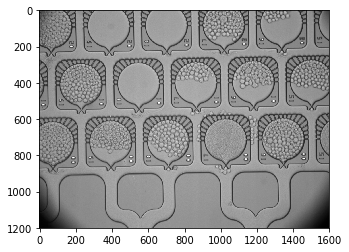

In [11]:
plt.imshow(img_raw)

In [12]:
acq = cytometry.Acquisition(config, img_path)

In [13]:
img = acq.load_image()
img.dtype, img.shape

(dtype('uint8'), (750, 1000, 3))

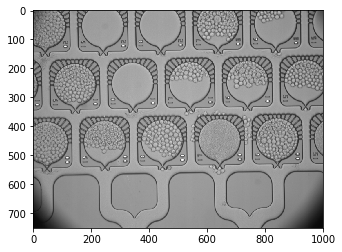

In [14]:
plt.imshow(img)

In [15]:
%%time
#acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=NO_IMAGES)
acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=ALL_IMAGES)
#acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=APT_IMAGES)

CPU times: user 7.01 s, sys: 5.26 s, total: 12.3 s
Wall time: 6.34 s


In [21]:
cytometer.save(acq_data, apt_data, cell_data)
cytometer.datastore.store.flush()
cytometer.images.store.flush()

In [16]:
acq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
acq_apartment             1 non-null object
acq_cell_line             1 non-null object
acq_datetime              1 non-null datetime64[ns]
acq_hours                 1 non-null object
acq_id                    1 non-null object
acq_processed_at          1 non-null datetime64[ns]
acq_street                1 non-null object
apt_count                 1 non-null int64
raw_image_path            1 non-null object
raw_image_shape_height    1 non-null int64
raw_image_shape_width     1 non-null int64
raw_norm_image            1 non-null object
rotation                  1 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory usage: 184.0+ bytes


In [17]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 39 columns):
acq_apartment             8 non-null object
acq_cell_line             8 non-null object
acq_datetime              8 non-null datetime64[ns]
acq_hours                 8 non-null object
acq_id                    8 non-null object
acq_processed_at          8 non-null datetime64[ns]
acq_street                8 non-null object
apt_id                    8 non-null int64
apt_image                 8 non-null object
apt_image_height          8 non-null int64
apt_image_width           8 non-null int64
apt_num                   8 non-null object
apt_num_digit_images      8 non-null object
apt_num_digit_scores      8 non-null object
apt_num_image             8 non-null object
cell_area_mean            6 non-null float64
cell_area_p10             6 non-null float64
cell_area_p50             6 non-null float64
cell_area_p90             6 non-null float64
cell_area_std             6 non-null float64
c

In [18]:
acq_data.rotation

0   -0.723393
Name: rotation, dtype: float64

In [19]:
#plt.imshow(acq_data.raw_norm_image.iloc[0])

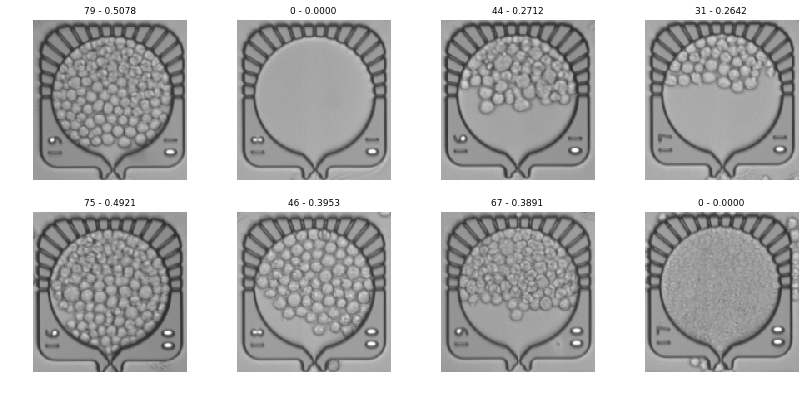

In [20]:
from cvutils.visualize import display_images
display_images(apt_data['apt_image'], titles=[
    '{} - {:.4f}'.format(r['cell_count'], r['occupancy_chamber']) for _, r in apt_data.iterrows()
])

00 03


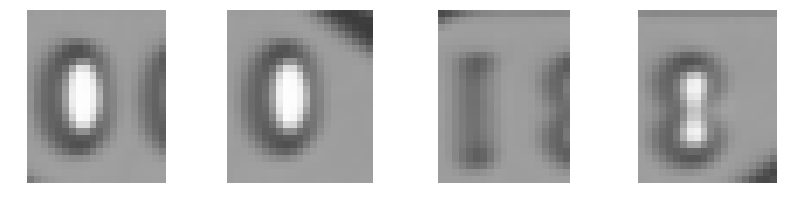

In [27]:
row = apt_data.iloc[5]
print(row['apt_num'], row['st_num'])
display_images(row['apt_num_digit_images'] + row['st_num_digit_images'])

In [22]:
row.filter(regex='scores')

apt_num_digit_scores    1.000,1.000
st_num_digit_scores     0.999,0.998
Name: 1, dtype: object

In [23]:
apt_data[['apt_num','st_num','cell_count']]

,apt_num,st_num,cell_count
0,01,69,79
1,01,18,0
2,01,16,44
3,01,17,31
4,00,06,75
5,00,03,46
6,00,69,67
7,00,17,0


In [24]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 66
Data columns (total 23 columns):
acq_apartment       342 non-null object
acq_cell_line       342 non-null object
acq_datetime        342 non-null datetime64[ns]
acq_hours           342 non-null object
acq_id              342 non-null object
acq_processed_at    342 non-null datetime64[ns]
acq_street          342 non-null object
apt_id              342 non-null int64
apt_num             342 non-null object
area                342 non-null int64
cell_id             342 non-null int64
cell_image          342 non-null object
centroid_x          342 non-null float64
centroid_y          342 non-null float64
eccentricity        342 non-null float64
in_chamber          342 non-null bool
roi_xmax            342 non-null int64
roi_xmin            342 non-null int64
roi_ymax            342 non-null int64
roi_ymin            342 non-null int64
score               342 non-null float64
solidity            342 non-null float64
st_n

In [34]:
cell_data.groupby(['in_chamber']).size()

in_chamber
True    9
dtype: int64